# Encoder / Decoder models

Encoding and decoding is a framework / approach rather than being a machine learning model. It usually includes two models, one encoding and the other one decoding. 

Especially useful for anomaly detection and denoising. 

The idea is you take a complex data, and try to represent it with as few as possible features. Then from these features you could re-trace your steps and recreate the original data but without the noise. 

Here, we will try to find the **latent** space for the triangles using the generated images. Ideally, we should be able to represent each with only 4 numbers; `a,b,c,` and an `angle`. Then we could use a decoder to either; recreate a new triangle image, or given 3 of the parameters, estimate the remaining one.

In [60]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Model
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, sys

# Add the project root to sys.path (one level up from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from hypotai.data import generate_triangle_data
from hypotai.models.convolutional import triangle_image_array
from hypotai.plotting import plot_triangle

Here we use a CNN to decode the triangles into a latent space.

(np.float64(0.0), np.float64(200.0), np.float64(0.0), np.float64(100.0))

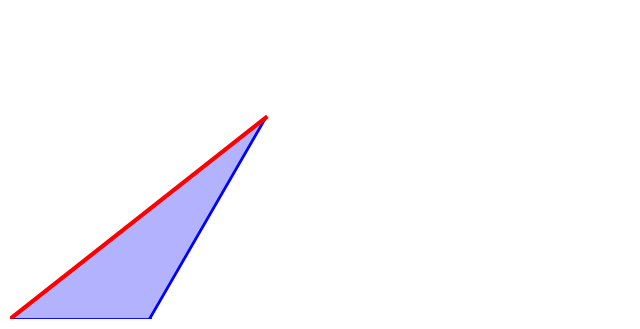

In [2]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_triangle(45,75,120, annotation=False, ax=ax)
ax.set_xlim(0, 200)
ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.axis("off")

We create new data. (I also want to keep the `df` of the original data)

In [ ]:
Nsamples = 1000

X = []
y = []
np.random.seed(42)
# generate triangle images and labels (can take a while)
df = generate_triangle_data(n_samples=Nsamples, angle_mode="random")
# for i in tqdm(range(Nsamples), total=Nsamples, desc="Generating triangle images"): # tqdm complains
for i in range(Nsamples):
    a, b, angle = df.iloc[i][["a", "b", "angle_deg"]]
    img = triangle_image_array(a, b, angle)
    # label
    c = df.iloc[i]["c"]
    
    X.append(img)
    y.append(c)

X = np.array(X)[..., np.newaxis]  # Shape (5000, 64, 64, 1)
y = np.array(y)

In [96]:
# Encoder
encoder = models.Sequential([
    layers.Input(shape=(64, 64, 1)),
    layers.GaussianNoise(0.1),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPooling2D(2),
    layers.GaussianNoise(0.1),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.GaussianNoise(0.1),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(15, name="latent_vector")  # bottleneck
])

Now, we want to "represent" each image with `m`-numbers, e.g. 4. If each image can be represented with 4 numbers, i.e. all information is still protected; we can use a decoder to train and learn these *latent* space numbers, or reconstruct the triangle images. This is actually, what it is done in every `Dense` layer. At the end, after all these filters with adjusted weights and biases, we put a `Flatten`+`Dense` layer which then takes **each pixel** and maps them to an outcome. Usually this outcome is a single value, i.e. we say "What is the length of the longest side" then the final layer gives us a number. Now, we ask "What are the 4 numbers that **best** represent this image".

To find the "best" representation, we still need to train with a given objective. Let's now try to train for reconstructing the images. i.e. "compress the image with CNN down to 4 numbers, then expand again using another CNN".

*edit: 4 was not enough, trying with 10.*

In [97]:
# --- Decoder ---
decoder = models.Sequential([
    layers.Input(shape=(15,)),

    # Reconstruct from latent space
    layers.Dense(4 * 4 * 32, activation='relu'),
    layers.Reshape((4, 4, 32)),

    # Deconvolution (reverse of Conv2D + Pooling)
    layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),  # 4→8
    layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu'),  # 8→16
    layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu'),   # 16→32
    layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same', activation='sigmoid') # 32→64 # sigmoid so the output img is in [0, 1]
])


In [98]:
encoder.summary()
decoder.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 60, 60, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 30, 30, 16)     │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (None, 14, 14, 32)     │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 15)             │        69,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,439 (325.93 KB)

 Trainable params: 83,439 (325.93 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 512)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 8, 8, 32)       │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 16, 16, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 32, 32, 8)      │         1,160 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 64, 64, 1)      │            73 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,297 (91.00 KB)

 Trainable params: 23,297 (91.00 KB)

 Non-trainable params: 0 (0.00 B)

Now we use "AutoEncoder" which takes the data and puts it through both encoder and decoder

In [99]:
# Combine them
autoencoder_input = layers.Input(shape=(64, 64, 1))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = Model(inputs=autoencoder_input, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Now to fit it.

In [100]:
history = autoencoder.fit(
        X, X,  # input == output since we are reconstructing the image
        epochs=40,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping], 
)

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.2370 - val_loss: 0.1965
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0890 - val_loss: 0.0100
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 7/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 8/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 9/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 10/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 11/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 12/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

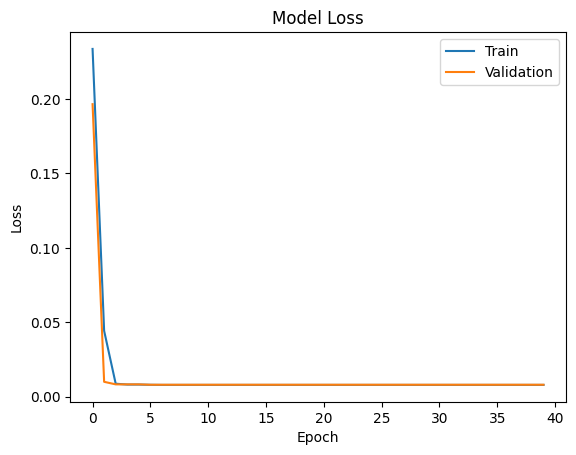

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [102]:
mean_squared_error(X.flatten(), autoencoder.predict(X).flatten())

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


0.007928161610459655

### Latent space and reconstruction

Since we passed 2 `models` to make 1 AutoEncoder `Model` that learns first how to compress, and then how to decompress, we can look at them individually.

In [103]:
latent_vectors = encoder.predict(X)
print(latent_vectors.shape)  # (N_samples, 4)
print(latent_vectors[:5]) 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1000, 15)
[[-541.03253  575.9906   535.8839  -558.86456  555.3527  -482.26895
  -504.41562 -420.99207 -477.05103 -469.1093  -512.05457 -513.48914
   452.20413 -598.0871  -529.6807 ]
 [-533.7967   568.4112   529.4428  -552.00665  547.9038  -476.54065
  -497.66037 -416.3804  -471.15228 -462.92212 -505.41937 -507.10504
   446.2514  -590.45056 -522.9166 ]
 [-540.96655  576.0128   535.8887  -558.84735  555.27106 -482.17038
  -504.43472 -420.95615 -477.02338 -469.00513 -511.9758  -513.52203
   452.15622 -598.08    -529.69196]
 [-539.0337   573.6937   533.7871  -556.74207  553.3411  -480.6081
  -502.42856 -419.34042 -475.08813 -467.45184 -510.20398 -511.5395
   450.4469  -595.76013 -527.5098 ]
 [-542.3513   577.50024  537.3031  -560.3226   556.66833 -483.36456
  -505.70535 -422.06265 -478.19766 -470.29407 -513.249   -514.7043
   453.30533 -599.5572  -531.06305]]


So this is what the encoder thinks the most useful  10  values to "learn what this image looks like".

In [104]:
i = 42  # sample index
recon = autoencoder.predict(X[i:i+1])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


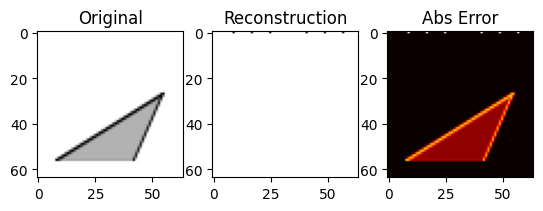

In [105]:
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(X[i].squeeze(), cmap="gray")

plt.subplot(1,3,2)
plt.title("Reconstruction")
plt.imshow(recon.squeeze(), cmap="gray")

plt.subplot(1,3,3)
plt.title("Abs Error")
plt.imshow(np.abs(X[i].squeeze() - recon.squeeze()), cmap="hot")


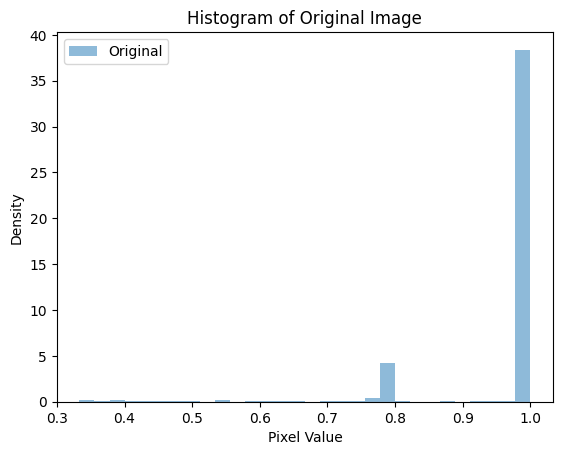

In [89]:
plt.hist(X[i].flatten(), density=True, bins=30, alpha=0.5, label="Original");
plt.xlabel("Pixel Value")
plt.ylabel("Density")
plt.title("Histogram of Original Image")
plt.legend()

So what happens is eventhough you have a **very low MSE** is that your model decides if it just assumes everything is always just 1. it is right most of the times. Look at the histogram above, in the triangle image, there are very few non-one pixels. So if you make a picture with only 1s then your picture is 99% correct. But that remaining 1% is the actual triangle we are looking for. 

In these kind of situations we need to explicitly tell where the important information is.

In [91]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    weights = K.cast(K.greater(y_true, 0.05), dtype='float32')
    return K.mean(weights * K.square(y_pred - y_true))

In [106]:
# Combine them
# autoencoder_input = layers.Input(shape=(64, 64, 1))
# encoded = encoder(autoencoder_input)
# decoded = decoder(encoded)

# autoencoder = Model(inputs=autoencoder_input, outputs=decoded)
autoencoder.compile(optimizer='adam', loss=weighted_mse)

history = autoencoder.fit(
        X, X,  # input == output since we are reconstructing the image
        epochs=40,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping], 
)

Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0076 - val_loss: 0.0080
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 7/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0078 - val_loss: 0.0080
Epoch 8/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 9/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 10/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 11/40
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0081

KeyboardInterrupt: 

In [ ]:
# Decoder (optional if reconstructing image)
decoder = models.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(8*8*64, activation='relu'),
    layers.Reshape((8, 8, 64)),
    layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),
    layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')  # Reconstructed image
])
